In [310]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, io
from fooof import FOOOFGroup

import warnings
warnings.filterwarnings("ignore")

sys.path.append('../')
import utils

font = {'family' : 'Helvetica',
        'weight' : 'regular',
        'size'   : 12}

import matplotlib
matplotlib.rc('font', **font)
C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']

save_plot = True
fig_path = '../figures/neurotycho/%s.pdf'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get spiking population time constants & ECoG electrode locations

In [184]:
# get mean population time constants, values grabbed from Murray et al., 2014
cell_ts = {'MT':[77.,64.], 'LIP':[138., 91.], 'LPFC':[184.,180.,195.,162.], 'OFC':[176.,188.], 'ACC':[313.,340.,257.], 'S1':[65.], 'S2':[149.]}
cell_ts_avg = {k: np.array([np.mean(np.array(v)/1e3), stats.sem(np.array(v)/1e3)*2]) for k,v in cell_ts.items()}

# electrode indices for each of the corresponding areas in each monkey
loc_inds_chibi = {'MT':[3,4,109], 'LIP':[10,11], 'LPFC':[14,15,25,26], 'OFC':[23,34,45], 'ACC':[52,57,58,59], 'S1':[9,19], 'S2':[95,108]}
loc_inds_george = {'MT':[4,13,22], 'LIP':[10,11,20,21], 'LPFC':[15,24,25,26], 'OFC':[45,66], 'ACC':[52,57,58,59], 'S1':[18,19,30], 'S2':[1,2,9,108]}
loc_inds = {'Chibi': loc_inds_chibi, 'George': loc_inds_george}

area_ord = [3,1,2,0,4,6,5] # color order to match Murray figure

# Collect fooof results and electrode info into Dataframe

In [3]:
# get cortex files
chibi_ctx_file = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/GridLocations/20110621KTMD_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_2Dimg/ChibiMap.mat'
george_ctx_file = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/GridLocations/20110112KTMD_Anesthesia+and+Sleep_George_Toru+Yanagawa_mat_2Dimg/GeorgeMap.mat'
ctx_loc = []
for ind, ctx_file in enumerate([chibi_ctx_file, george_ctx_file]):
    ctx_mat = io.loadmat(ctx_file, squeeze_me=True)
    ctx_loc.append(np.array([ctx_mat['X'], ctx_mat['Y']]).T)

In [234]:
win_len, p_cur = '1sec', 'psd_med'
fg_param_to_load = 'knee'
df_combined = pd.DataFrame()
col_names = ['patient','cond','pharm', 'session_id', 'chan', 'exp', 'knee', 'tau','log_tau','err', 'r2']

# load fooof results
result_basepath = '/Users/rdgao/Documents/code/research/field-echos/results/neurotycho/rest_anes/'
session_resultpath = np.sort([f+'/' for f in os.listdir(result_basepath) if os.path.isdir(result_basepath+f)])
session_dict = {id:ind for ind, id in enumerate(np.unique([s.split('_')[3] for s in session_resultpath]))}
for s in session_resultpath:
    fooof_folder = result_basepath + s +'/psd/'+win_len+'/fooof/'+p_cur+'/'    
    ff_list = [ff for ff in os.listdir(fooof_folder) if '.json' in ff]
    ff_file = ff_list[np.where([fg_param_to_load in f for f in ff_list])[0][0]] # load specific fooof file
    
    # return fooof fits and convert knee to tau
    fg_aps, fg_pks, fg_err, fg_r2s = utils.return_fg_fits(ff_file, fooof_folder)
    if fg_aps.shape[1]==3:
        knee_freq, knee_tau = utils.convert_knee_val(fg_aps[:,1],fg_aps[:,2])
        knee = fg_aps[:,1]
    else:
        knee_tau = np.zeros_like(fg_aps[:,0])
        knee = np.zeros_like(fg_aps[:,0])
    
    df_data = np.vstack((fg_aps[:,-1], knee, knee_tau, np.log10(knee_tau), fg_err, fg_r2s)).T
    s_spl = s.split('_')
    patient, cond, pharm, session_id = s_spl[7], s_spl[1], s_spl[2], session_dict[s_spl[3]]
    chan = np.arange(len(fg_err))+1
    df_cur = pd.DataFrame(np.hstack((np.repeat(np.array([patient,cond,pharm, session_id])[:,None].T, len(fg_err), axis=0), chan[:,None], df_data))
                 ,columns=col_names)
    df_cur.insert(5,'y', ctx_loc[0 if patient is 'Chibi' else 1][:,0])
    df_cur.insert(6,'z', ctx_loc[0 if patient is 'Chibi' else 1][:,1])

    df_combined = df_combined.append(df_cur, ignore_index=True)

df_combined.columns
df_combined = df_combined.astype({c:str if c in ['patient', 'cond', 'pharm'] else np.float for c in col_names})

# plot tau-exp correlation

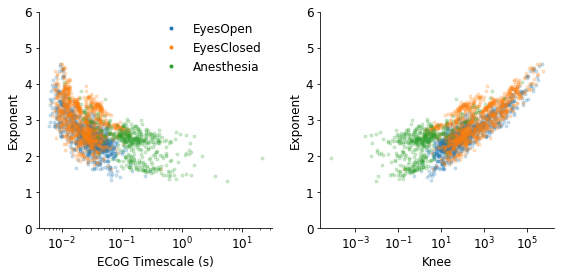

In [180]:
plt.figure(figsize=(8,4))
for cond in df_combined['cond'].unique()[[0,1,3]]:
    df_plot = df_combined[df_combined['cond']==cond]
    plt.subplot(1,2,1)
    plt.semilogx(df_plot['tau'],df_plot['exp'],'.', alpha=0.2, label=cond)
    plt.xlabel('ECoG Timescale (s)'); plt.ylabel('Exponent'); plt.ylim([0, 6]); utils.remove_spines(plt.gca())
    # knee-exp
    plt.subplot(1,2,2)
    plt.semilogx(df_plot['knee'],df_plot['exp'],'.', alpha=0.2, label=cond)
    plt.xlabel('Knee'); plt.ylabel('Exponent'); plt.ylim([0, 6]); utils.remove_spines(plt.gca())   

plt.subplot(1,2,1); 
lg=plt.legend(fancybox=False, frameon=False)
for l in lg.legendHandles: l._legmarker.set_alpha(1)
plt.tight_layout()
if save_plot: plt.savefig(fig_path%'NT_exp_knee')

# plot tau along anterior-posterior axis

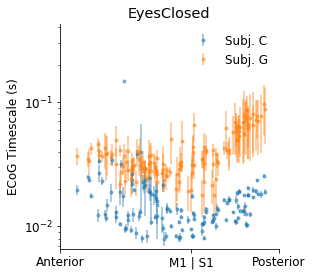

In [312]:
feature = 'tau'
cond_query = 'EyesClosed'
df_cond = df_combined[df_combined['cond']==cond_query] 

plt.figure(figsize=(4.5,4))
# group by subject at the highest level, then channel, then perform average (over sessions)
grand_agg = df_cond.groupby(['patient', 'chan'])[df_combined.columns[3:]].agg([np.nanmean, stats.sem])
for g_i, g in grand_agg.groupby('patient'):
    plt.errorbar(g['y']['nanmean'], g[feature]['nanmean'], yerr=g[feature]['sem']*2., fmt='.', alpha=0.5)
    # normalize per subject
    #plt.errorbar(g['y']['nanmean'], g[feature]['nanmean']/g[feature]['nanmean'].min(), yerr=g[feature]['sem']*2., fmt='.')
    
plt.yscale('log'); plt.legend(['Subj. C', 'Subj. G'], frameon=False); 
utils.remove_spines(plt.gca())
plt.xticks([0,600,1000],['Anterior','M1 | S1','Posterior'])
plt.ylabel('ECoG Timescale (s)'); plt.title(cond_query)
plt.tight_layout()
if save_plot: plt.savefig(fig_path%('NT_TauAcrossAP_'+cond_query))

Timescale increases from central sulcus towards frontal and occiptal poles.

# Test correlation with monkey spiking dataset

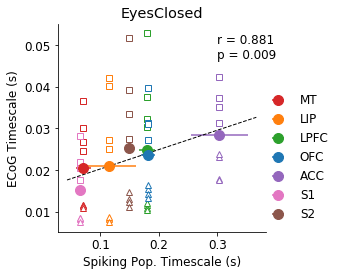

In [290]:
cond_query = 'EyesClosed'
df_cond = df_combined[df_combined['cond']==cond_query] 
plt.figure(figsize=(4,4))
ecog_ts_avg = {}
# plot per session average across electrodes
for i, k in enumerate(cell_ts.keys()):
    sesh_mkrs = [] # hack to save the session marker for next plot
    ecog_ts_avg[k] = []
    for s in df_cond['session_id'].unique():
        df_sesh = df_cond[df_cond['session_id']==s]
        patient = df_sesh['patient'].iloc[0]

        # loc_inds has the ecog electrode indices that fall into each area
        region_inds = loc_inds[patient][k] 
        marker = 's' if patient == 'George' else '^'
        sesh_mkrs.append(marker)
        ecog_ts_sess_avg = df_sesh.loc[df_sesh['chan'].isin(region_inds)].mean()[feature]
        ecog_ts_avg[k].append(ecog_ts_sess_avg)
        plt.plot(cell_ts_avg[k][0], ecog_ts_sess_avg, marker,color=C_ORD[area_ord[i]], ms=6, mfc='w')

# plot grand average
for i,k in enumerate(cell_ts.keys()):
    plt.errorbar(cell_ts_avg[k][0], np.mean(ecog_ts_avg[k]), xerr=cell_ts_avg[k][1], fmt='o', color=C_ORD[area_ord[i]], ms=10, label=k)

# fit & plot line
ts_mat = np.array([(cell_ts_avg[k][0], np.mean(ecog_ts_avg[k])) for k in cell_ts.keys()])
m,b,r,pv,stderr = stats.linregress(ts_mat)
XL = np.array(plt.xlim())
plt.plot(XL,XL*m+b, 'k--', lw=1)
plt.text(0.3,0.85*plt.ylim()[1], 'r = %.3f\np = %.3f'%(r,pv))

plt.legend(loc='lower left', bbox_to_anchor= (0.95, 0), ncol=1, frameon=False)
plt.xlabel('Spiking Pop. Timescale (s)');plt.ylabel('ECoG Timescale (s)'); plt.title(cond_query)
utils.remove_spines(plt.gca()); plt.tight_layout()
if save_plot: plt.savefig(fig_path%('NT_spikeECoG_'+cond_query), bbox_inches='tight')

# Fitting linear model to each session

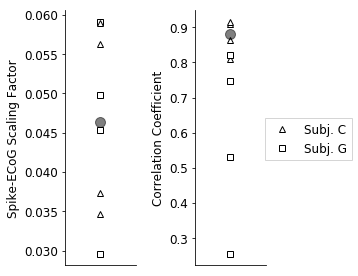

In [291]:
ecog_ts_mat = np.array([ecog_ts_avg[k] for k in cell_ts.keys()])
cell_ts_mat = np.array([cell_ts_avg[k][0] for k in cell_ts.keys()])
session_stats = np.array([stats.linregress(cell_ts_mat, ecog_ts_mat[:,i]) for i in range(ecog_ts_mat.shape[1])])

plt.figure(figsize=(4,4))
plt.subplot(1,2,1)
for s_i, s in enumerate(sesh_mkrs): plt.plot(0, session_stats[s_i,0], mec='k', mfc='w', ms=6, marker=s)
plt.plot(0, m,'ko', ms=10, alpha=0.5)
utils.remove_spines(plt.gca(), ['right', 'top'])
plt.xticks([]); plt.ylabel('Spike-ECoG Scaling Factor')

plt.subplot(1,2,2)
for s_i, s in enumerate(sesh_mkrs): plt.plot(0, session_stats[s_i,2],mec='k', mfc='w', ms=6, marker=s)
plt.plot(0, r,'ko', ms=10, alpha=0.5)
utils.remove_spines(plt.gca(), ['right', 'top'])
plt.xticks([]); plt.ylabel('Correlation Coefficient')
lg = plt.legend(['Subj. C','Subj. G'], bbox_to_anchor= (2.3, 0.6), fancybox=False)
for l in lg.legendHandles: l.set_linewidth(0)
plt.tight_layout(); 
if save_plot: plt.savefig(fig_path%('NT_EcoGSpikeScaling_'+cond_query), bbox_inches='tight')

# Comparing across conditions

True
True
True
True
True
True
True
True


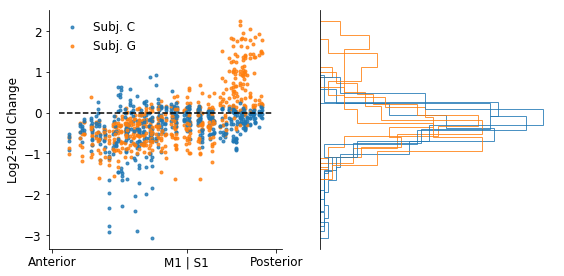

In [309]:
feature = 'tau'
conds_comp = ['EyesOpen','EyesClosed']
plt.figure(figsize=(8,4))
for s in df_combined['session_id'].unique():
    df_comp = [df_combined[np.logical_and(df_combined['cond']==c, df_combined['session_id']==s)] for c in conds_comp]

    # check that the subsampled rows are properly aligned in space and session
    print(np.logical_and(df_comp[1]['y']==df_comp[1]['y'],df_comp[1]['session_id']==df_comp[1]['session_id']).all())
    cond_ratio = np.log2(df_comp[1][feature].values/df_comp[0][feature].values)
    C = C_ORD[0 if df_comp[0].iloc[0]['patient']=='Chibi' else 1]

    # plot along A-P axis
    plt.subplot(1,2,1)
    plt.plot(df_comp[1]['y'], cond_ratio, '.', color=C, alpha=0.8)
    
    # plot histogram
    plt.subplot(1,2,2)
    plt.hist(cond_ratio[~np.isnan(cond_ratio)], 10, histtype='step', color=C, orientation='horizontal', alpha=0.8)

plt.subplot(1,2,1)
plt.plot(plt.xlim(),[0,0],'k--')
plt.legend(['Subj. C', 'Subj. G'], frameon=False); 
plt.xticks([0,600,1000],['Anterior','M1 | S1','Posterior'])
plt.ylabel('Log2-fold Change');
utils.remove_spines(plt.gca())

plt.subplot(1,2,2)
plt.xticks([]); plt.yticks([])
utils.remove_spines(plt.gca(), ['right', 'top', 'bottom'])
plt.tight_layout()
if save_plot: plt.savefig(fig_path%('NT_EO2EC'), bbox_inches='tight')

In [6]:

# group_agg = pd.DataFrame()
# for group_id, group in df.groupby(group_col[0][0]):
#     group_agg = group_agg.append(group.groupby(group_col[0][1]).aggregate(aggr_func))

#df_combined[df_combined['cond']==0].groupby('patient').mean()
# def collect_results(param_choice, fooof_files, output_file, save_plot=False):
#     fits, subj = [],[]
#     for ff in fooof_files:
#         metadata = [ff.split('_')[i] for i in [0,1,2,5,11]]
#         if set(param_choice[:-1]) < set(metadata):        
#             fg = FOOOFGroup()
#             fg.load(ff, fooof_path)
#             bg = fg.get_all_data('aperiodic_params')
#             ftns = np.array([fg.get_all_data('r_squared'),fg.get_all_data('error')]).T
#             fits.append(np.hstack([bg, ftns]))
#             subj.append(metadata[-1])

#     if subj == []:
#         raise ValueError('Parameter combination did not return valid result.')
#     fits = np.dstack(fits)
    
#     # collect data from electrodes
#     cell_ts = {'MT':[77.,64.], 'LIP':[138., 91.], 'LPFC':[184.,180.,195.,162.], 'OFC':[176.,188.], 'ACC':[313.,340.,257.], 'S1':[65.], 'S2':[149.]}
#     cell_ts_avg = {}

#     # consult map for these coords
#     loc_inds_chibi = {'MT':[3,4,109], 'LIP':[10,11], 'LPFC':[14,15,25,26], 'OFC':[23,34,45], 'ACC':[52,57,58,59], 'S1':[9,19], 'S2':[95,108]}
#     loc_inds_george = {'MT':[4,13,22], 'LIP':[10,11,20,21], 'LPFC':[15,24,25,26], 'OFC':[45,66], 'ACC':[52,57,58,59], 'S1':[18,19,30], 'S2':[1,2,9,108]}
#     loc_inds = {'Chibi': loc_inds_chibi, 'George': loc_inds_george}

#     # collect all data
#     ecog_ts = {}
#     ecog_ts_avg = {}
#     for i,key in enumerate(cell_ts.keys()):
#         ecog_ts[key]=[]
#         for rec in range(fits.shape[2]):
#             cur_locs = np.array(loc_inds[subj[rec]][key])-1
#             # check that knee was fit 
#             if (param_choice[-1] is 'knee' or param_choice[-1] is 'kneeslope') and (param_choice[-2] is not 'knee'):
#                 raise ValueError('Cannot extract knee parameter, linear fit was performed.')

#             # grab feature
#             if param_choice[-1] is 'knee':
#                 ecog_ts[key].append(tau_from_knee(fits[cur_locs,1,rec])*1000)
#             elif param_choice[-1] is 'kneeslope':
#                 ecog_ts[key].append(tau_from_kneeslope(fits[cur_locs,1,rec],fits[cur_locs,2,rec])*1000)
#             elif param_choice[-1] is 'slope':
#                 # negative because fooof outputs positive exponent
#                 ecog_ts[key].append(-fits[cur_locs,-3,rec])
#             elif param_choice[-1] is 'offset':
#                 ecog_ts[key].append(fits[cur_locs,0,rec])
#             elif param_choice[-1] is 'error':
#                 ecog_ts[key].append(fits[cur_locs,-1,rec])
#             elif param_choice[-1] is 'r2':
#                 ecog_ts[key].append(fits[cur_locs,-2,rec])

#         # average over all electrodes within a single recording
#         ecog_ts_avg[key] = np.array([[np.nanmean(ts), nan_95(ts)] for ts in ecog_ts[key]])
#         cell_ts_avg[key] = np.array([np.mean(cell_ts[key]), nan_95(np.array(cell_ts[key]))])

#         # average over session and subject
#         per_session = [{key: ecog_ts_avg[key][rec,:] for key in ecog_ts_avg.keys()} for rec in range(len(subj))]
#         monkeys, subj_ind = np.unique(subj, return_inverse=True) # get subject indices
#         per_subj = [{key: np.array([np.nanmean(ecog_ts_avg[key][subj_ind==s,0]), nan_95(ecog_ts_avg[key][subj_ind==s,0])]) for key in ecog_ts_avg.keys()} for s in np.unique(subj_ind)]    

#         # grand average: average over all sessions
#         ecog_ts_grandavg = {key: [np.nanmean(ecog_ts_avg[key][:,0]), nan_95(ecog_ts_avg[key][:,0])] for key in ecog_ts_avg.keys()}

#     # plotting params
#     markers=['D','v']

#     plt.figure(figsize=(15,5))
#     h_r = plt.subplot(2,3,3, title='Pearson Correlation')
#     h_w = plt.subplot(2,3,6, title='ECoG:Spiking Conversion Factor')
#     plt_ctr = 0

#     print('Grand Average')
#     plt.subplot(1,3,1)
#     stats_collect = plot_ts_correlations(ecog_ts_grandavg, cell_ts_avg, marker='o', ms=8)
#     h_r.bar(plt_ctr,stats_collect[0], color='k')
#     h_w.bar(plt_ctr,stats_collect[2], color='k')
#     plt.title('Grand Average');
#     plt_ctr+=1

#     print('Subject Average')
#     for s in range(2):
#         plt.subplot(1,3,2)
#         stats_collect=plot_ts_correlations(per_subj[s], cell_ts_avg, marker=markers[s], ms=8, show_legend=False)
#         h_r.bar(plt_ctr,stats_collect[0], color=CKEYS[s])
#         h_w.bar(plt_ctr,stats_collect[2], color=CKEYS[s])
#         plt_ctr+=1
#     plt.title('Subject Average')
#     plt.tight_layout()

#     print('Per Session')
#     sess_sorted = np.hstack((np.where(np.arange(len(subj))[1-subj_ind]), np.where(np.arange(len(subj))[subj_ind])))[0]
#     plt.figure(figsize=(15,8))
#     for exp in range(fits.shape[2]):
#         plt.subplot(2,4,exp+1)
#         stats_collect=plot_ts_correlations(per_session[sess_sorted[exp]], cell_ts_avg, marker='.', show_legend=False)
#         plt.title(subj[sess_sorted[exp]])
#         h_r.bar(plt_ctr,stats_collect[0], color=CKEYS[subj_ind[sess_sorted[exp]]], ec='k', alpha=0.4)
#         h_w.bar(plt_ctr,stats_collect[2], color=CKEYS[subj_ind[sess_sorted[exp]]], ec='k', alpha=0.4)
#         plt_ctr+=1
#     plt.tight_layout()
#     if save_plot:
#         plt.savefig(output_file+'_per_subj.png', frameon=False)

#     h_r.set_xticks([])
#     h_w.set_xticks([0,1,2])
#     h_w.set_xticklabels(['A','M1','M2'])
#     plt.tight_layout()
#     if save_plot:
#         plt.sca(h_r)
#         plt.savefig(output_file+'_aggregate.png', frameon=False)
        
#     return cell_ts_avg, ecog_ts_grandavg, per_subj, per_session

(<pandas.core.groupby.DataFrameGroupBy object at 0x1a1fb73ac8>,
        patient  cond  pharm       exp           knee       tau   log_tau  \
 chan                                                                       
 1.0        0.0   0.0    0.5  3.222923    9352.996784  0.009848 -2.008714   
 2.0        0.0   0.0    0.5  3.740038   51238.477895  0.009166 -2.039027   
 3.0        0.0   0.0    0.5  3.392594   10378.574509  0.010871 -1.964922   
 4.0        0.0   0.0    0.5  3.375175   11021.023502  0.010772 -1.969280   
 5.0        0.0   0.0    0.5  2.509180    2634.244752  0.013253 -1.938449   
 6.0        0.0   0.0    0.5  3.407602   58003.208006  0.007084 -2.152075   
 7.0        0.0   0.0    0.5  2.695557    3531.984412  0.010388 -2.003922   
 8.0        0.0   0.0    0.5  1.628172      19.464945  0.045687 -1.387316   
 9.0        0.0   0.0    0.5  3.163089   16856.880521  0.008111 -2.093813   
 10.0       0.0   0.0    0.5  3.754153  103207.387574  0.008198 -2.088689   
 11.0       

In [4]:
# load psd, fooof & dfa results
# def load_results(basefolder, filename, load_psd=True, load_fooof=True, load_dfa=True):
#     psd_data, fooof_data, dfa_data = [], [], []
#     if load_psd:
#         psd_data = np.load(basefolder+'psd/'+filename)
#         print(list(psd_data.keys()))
#     if load_fooof:
#         fooof_data = np.load(basefolder+'psd/fooof/'+filename)
#         print(list(fooof_data.keys()))
#     if load_dfa:    
#         dfa_data = np.load(basefolder+'dfa/'+filename)
#         print(list(dfa_data.keys()))
    
#     return psd_data, fooof_data, dfa_data


def load_fooof_object(basefolder, filename, settings):
    return

def load_fooof_results(basefolder, filename):
    fooof_data = np.load(basefolder+filename)
    print(list(fooof_data.keys()))
    return fooof_data

def tau_from_knee(knee):
    return knee**-0.5/(2*np.pi)

def tau_from_kneeslope(knee, slope):
    return knee**(-1./slope)/(2*np.pi)

def nan_95(x):
    return 1.96*np.nanstd(x)/(x.shape[0]-sum(np.isnan(x)))**0.5

def plot_ts_correlations(ecog_ts, cell_ts, marker, ms=12, plot_cf=True, plot_regr=True, show_legend=True):    
    for i,key in enumerate(cell_ts.keys()):
        curr_c=CKEYS[C_ord[i]]
        if plot_cf:
            plt.errorbar(cell_ts[key][0], ecog_ts[key][0], ecog_ts[key][1],cell_ts[key][1], fmt=marker, ms=ms, label=key, color=curr_c)
        else:
            plt.plot(cell_ts[key][0], ecog_ts[key][0], marker, ms=ms, label=key, color=curr_c)
    
    if show_legend: plt.legend()
    plt.xlabel('Single Unit Time Constant (ms)')
    plt.ylabel('ECoG Time Constant (ms)')

    # stats on grand average
    ts_means = np.array([[cell_ts[key][0], ecog_ts[key][0]] for key in cell_ts.keys()])
    XL = np.array(plt.xlim())
    try:
        W = np.polyfit(ts_means[:,0],ts_means[:,1],1)
    except:
        print('Regression did not converge.')
        W = [0.,0.]
    if plot_regr:
        plt.plot(XL, XL*W[0]+W[1], 'k--', lw=1)
    rho,pv = sp.stats.pearsonr(ts_means[:,0], ts_means[:,1])
    print('rho=%.3f, p-value=%.3f, TS factor=%0.3f'%(rho,pv,W[0]))
    return rho, pv, W[0]

In [5]:
# fooof_path = '/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/'
# fooof_files = sorted([ff for ff in os.listdir(fooof_path) if '.npz' in ff])
# # parameter options
# conds = ['EyesOpen', 'EyesClosed', 'Delivery', 'Anesthesia']
# mean_or_med = ['psdmean', 'psdmed']
# frange_params = ['1-70', '1-7', '30-70', '0-70', '0-7']
# fixed_or_knee = ['fixed','knee']
# fit_feats = ['knee','slope','kneeslope','offset', 'error']

# # specifying parameter combinations
# param_choice = [conds[0], mean_or_med[1], frange_params[0], fixed_or_knee[1], fit_feats[0]]
# print(param_choice)

In [8]:
def collect_results(param_choice, fooof_files, output_file, save_plot=False):
    fits, subj = [],[]
    for ff in fooof_files:
        metadata = [ff.split('_')[i] for i in [0,1,2,5,11]]
        if set(param_choice[:-1]) < set(metadata):        
            fg = FOOOFGroup()
            fg.load(ff, fooof_path)
            bg = fg.get_all_data('aperiodic_params')
            ftns = np.array([fg.get_all_data('r_squared'),fg.get_all_data('error')]).T
            fits.append(np.hstack([bg, ftns]))
            subj.append(metadata[-1])

    if subj == []:
        raise ValueError('Parameter combination did not return valid result.')
    fits = np.dstack(fits)
    
    # collect data from electrodes
    cell_ts = {'MT':[77.,64.], 'LIP':[138., 91.], 'LPFC':[184.,180.,195.,162.], 'OFC':[176.,188.], 'ACC':[313.,340.,257.], 'S1':[65.], 'S2':[149.]}
    cell_ts_avg = {}

    # consult map for these coords
    loc_inds_chibi = {'MT':[3,4,109], 'LIP':[10,11], 'LPFC':[14,15,25,26], 'OFC':[23,34,45], 'ACC':[52,57,58,59], 'S1':[9,19], 'S2':[95,108]}
    loc_inds_george = {'MT':[4,13,22], 'LIP':[10,11,20,21], 'LPFC':[15,24,25,26], 'OFC':[45,66], 'ACC':[52,57,58,59], 'S1':[18,19,30], 'S2':[1,2,9,108]}
    loc_inds = {'Chibi': loc_inds_chibi, 'George': loc_inds_george}

    # collect all data
    ecog_ts = {}
    ecog_ts_avg = {}
    for i,key in enumerate(cell_ts.keys()):
        ecog_ts[key]=[]
        for rec in range(fits.shape[2]):
            cur_locs = np.array(loc_inds[subj[rec]][key])-1
            # check that knee was fit 
            if (param_choice[-1] is 'knee' or param_choice[-1] is 'kneeslope') and (param_choice[-2] is not 'knee'):
                raise ValueError('Cannot extract knee parameter, linear fit was performed.')

            # grab feature
            if param_choice[-1] is 'knee':
                ecog_ts[key].append(tau_from_knee(fits[cur_locs,1,rec])*1000)
            elif param_choice[-1] is 'kneeslope':
                ecog_ts[key].append(tau_from_kneeslope(fits[cur_locs,1,rec],fits[cur_locs,2,rec])*1000)
            elif param_choice[-1] is 'slope':
                # negative because fooof outputs positive exponent
                ecog_ts[key].append(-fits[cur_locs,-3,rec])
            elif param_choice[-1] is 'offset':
                ecog_ts[key].append(fits[cur_locs,0,rec])
            elif param_choice[-1] is 'error':
                ecog_ts[key].append(fits[cur_locs,-1,rec])
            elif param_choice[-1] is 'r2':
                ecog_ts[key].append(fits[cur_locs,-2,rec])

        # average over all electrodes within a single recording
        ecog_ts_avg[key] = np.array([[np.nanmean(ts), nan_95(ts)] for ts in ecog_ts[key]])
        cell_ts_avg[key] = np.array([np.mean(cell_ts[key]), nan_95(np.array(cell_ts[key]))])

        # average over session and subject
        per_session = [{key: ecog_ts_avg[key][rec,:] for key in ecog_ts_avg.keys()} for rec in range(len(subj))]
        monkeys, subj_ind = np.unique(subj, return_inverse=True) # get subject indices
        per_subj = [{key: np.array([np.nanmean(ecog_ts_avg[key][subj_ind==s,0]), nan_95(ecog_ts_avg[key][subj_ind==s,0])]) for key in ecog_ts_avg.keys()} for s in np.unique(subj_ind)]    

        # grand average: average over all sessions
        ecog_ts_grandavg = {key: [np.nanmean(ecog_ts_avg[key][:,0]), nan_95(ecog_ts_avg[key][:,0])] for key in ecog_ts_avg.keys()}

    # plotting params
    markers=['D','v']

    plt.figure(figsize=(15,5))
    h_r = plt.subplot(2,3,3, title='Pearson Correlation')
    h_w = plt.subplot(2,3,6, title='ECoG:Spiking Conversion Factor')
    plt_ctr = 0

    print('Grand Average')
    plt.subplot(1,3,1)
    stats_collect = plot_ts_correlations(ecog_ts_grandavg, cell_ts_avg, marker='o', ms=8)
    h_r.bar(plt_ctr,stats_collect[0], color='k')
    h_w.bar(plt_ctr,stats_collect[2], color='k')
    plt.title('Grand Average');
    plt_ctr+=1

    print('Subject Average')
    for s in range(2):
        plt.subplot(1,3,2)
        stats_collect=plot_ts_correlations(per_subj[s], cell_ts_avg, marker=markers[s], ms=8, show_legend=False)
        h_r.bar(plt_ctr,stats_collect[0], color=CKEYS[s])
        h_w.bar(plt_ctr,stats_collect[2], color=CKEYS[s])
        plt_ctr+=1
    plt.title('Subject Average')
    plt.tight_layout()

    print('Per Session')
    sess_sorted = np.hstack((np.where(np.arange(len(subj))[1-subj_ind]), np.where(np.arange(len(subj))[subj_ind])))[0]
    plt.figure(figsize=(15,8))
    for exp in range(fits.shape[2]):
        plt.subplot(2,4,exp+1)
        stats_collect=plot_ts_correlations(per_session[sess_sorted[exp]], cell_ts_avg, marker='.', show_legend=False)
        plt.title(subj[sess_sorted[exp]])
        h_r.bar(plt_ctr,stats_collect[0], color=CKEYS[subj_ind[sess_sorted[exp]]], ec='k', alpha=0.4)
        h_w.bar(plt_ctr,stats_collect[2], color=CKEYS[subj_ind[sess_sorted[exp]]], ec='k', alpha=0.4)
        plt_ctr+=1
    plt.tight_layout()
    if save_plot:
        plt.savefig(output_file+'_per_subj.png', frameon=False)

    h_r.set_xticks([])
    h_w.set_xticks([0,1,2])
    h_w.set_xticklabels(['A','M1','M2'])
    plt.tight_layout()
    if save_plot:
        plt.sca(h_r)
        plt.savefig(output_file+'_aggregate.png', frameon=False)
        
    return cell_ts_avg, ecog_ts_grandavg, per_subj, per_session

['EyesOpen', 'psdmean', '1-70', 'fixed', 'slope']
Grand Average
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Subject Average
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Per Session
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
['EyesOpen', 'psdmean', '1-70', 'fixed', 'offset']
Grand Average
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Subject Average

Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
['EyesOpen', 'psdmean', '1-70', 'knee', 'kneeslope']
Grand Average
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Subject Average
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Per Session
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
['EyesOpen', 'psdmean', '1-70', 'knee', 'offset']
Grand Average
Regression di

Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
['EyesOpen', 'psdmed', '30-70', 'fixed', 'error']
Grand Average
rho=-0.459, p-value=0.300, TS factor=-0.000
Subject Average
rho=0.721, p-value=0.068, TS factor=0.000
rho=-0.806, p-value=0.028, TS factor=-0.000
Per Session
rho=0.468, p-value=0.289, TS factor=0.000
rho=0.741, p-value=0.057, TS factor=0.000
rho=0.193, p-value=0.678, TS factor=0.000
rho=0.800, p-value=0.031, TS factor=0.000
rho=-0.750, p-value=0.052, TS factor=-0.000
rho=-0.830, p-value=0.021, TS factor=-0.000
rho=-0.897, p-value=0.006, TS factor=-0.000
rho=-0.237, p-value=0.608, TS factor=-0.000
['EyesOpen', 'psdmed', '1-70', 'knee', 'knee']
Grand Average
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Subject Average
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Per Session
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000


Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
['EyesClosed', 'psdmean', '1-7', 'fixed', 'error']
Grand Average
rho=0.468, p-value=0.289, TS factor=0.000
Subject Average
rho=0.595, p-value=0.159, TS factor=0.000
rho=-0.394, p-value=0.382, TS factor=-0.000
Per Session
rho=0.398, p-value=0.377, TS factor=0.000
rho=0.534, p-value=0.217, TS factor=0.000
rho=0.656, p-value=0.109, TS factor=0.000
rho=0.675, p-value=0.096, TS factor=0.000
rho=-0.057, p-value=0.904, TS factor=-0.000
rho=-0.601, p-value=0.153, TS factor=-0.000
rho=-0.045, p-value=0.924, TS factor=-0.000
rho=-0.484, p-value=0.271, TS factor=-0.000
['EyesClosed', 'psdmean', '30-70', 'fixed', 'slope']
Grand Average
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Subject Average
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regress

Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
['EyesClosed', 'psdmed', '1-70', 'fixed', 'error']
Grand Average
rho=-0.861, p-value=0.013, TS factor=-0.000
Subject Average
rho=-0.699, p-value=0.081, TS factor=-0.000
rho=-0.858, p-value=0.013, TS factor=-0.000
Per Session
rho=-0.568, p-value=0.183, TS factor=-0.000
rho=-0.592, p-value=0.161, TS factor=-0.000
rho=-0.757, p-value=0.049, TS factor=-0.000
rho=-0.497, p-value=0.256, TS factor=-0.000


KeyboardInterrupt: 

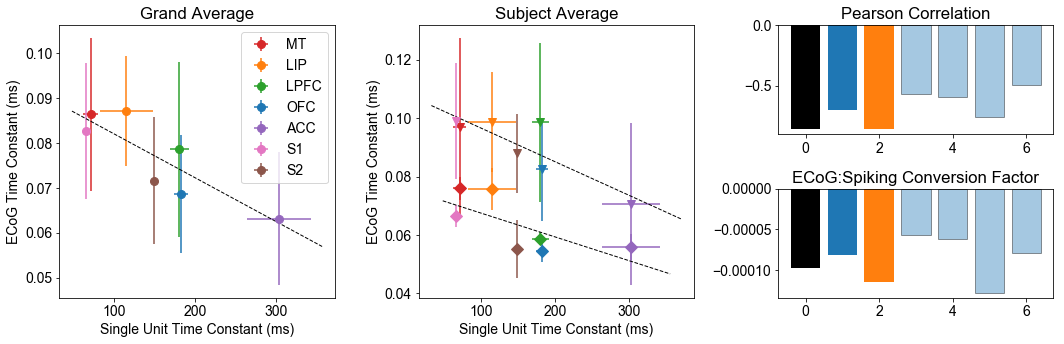

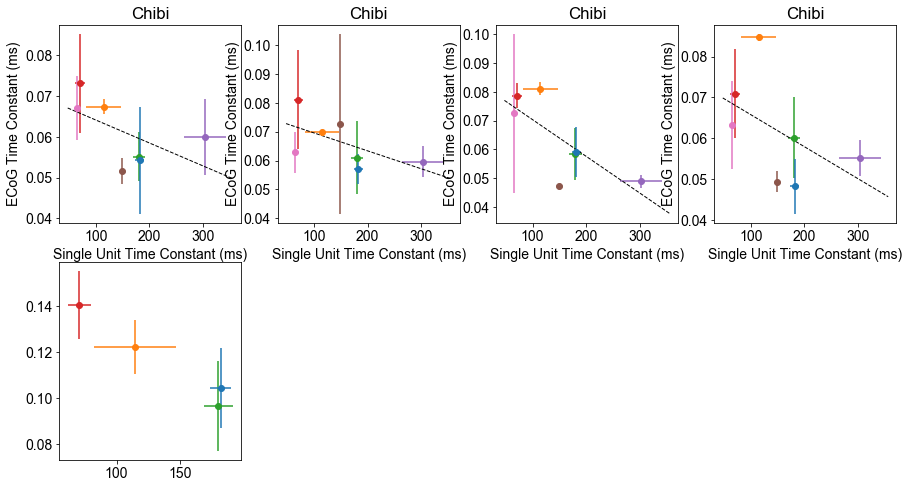

In [9]:
C_ord = [3,1,2,0,4,6,5]
CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']

# parameter options
conds = ['EyesOpen', 'EyesClosed', 'Delivery', 'Anesthesia']
mean_or_med = ['psdmean', 'psdmed']
frange_params = ['1-70', '1-7', '30-70', '0-70', '0-7']
fixed_or_knee = ['fixed','knee']
fit_feats = ['knee','slope','kneeslope','offset', 'error']

# 1sec
fooof_path = '/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/'
fooof_files = sorted([ff for ff in os.listdir(fooof_path) if '.npz' in ff])
for p_c in conds[:2]:
    for p_p in mean_or_med:
        for p_bg in fixed_or_knee:
            if p_bg is 'fixed':
                for p_f in frange_params[:3]:
                    for p_ff in ['slope','offset', 'error']:
                        param_choice = [p_c, p_p, p_f, p_bg, p_ff]                        
                        print(param_choice)
                        output_name = 'timescale_results/1sec/'+'_'.join(param_choice)
                        collect_results(param_choice, fooof_files, output_name)
                        plt.close('all')
            else:
                for p_ff in fit_feats:
                    param_choice = [p_c, p_p, frange_params[0], p_bg, p_ff]
                    print(param_choice)
                    output_name = 'timescale_results/1sec/'+'_'.join(param_choice)
                    collect_results(param_choice, fooof_files, output_name)
                    plt.close('all')

Grand Average
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Subject Average
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Per Session
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS factor=0.000
Regression did not converge.
rho=nan, p-value=1.000, TS facto

Text(0.5,1,'EyesOpen')

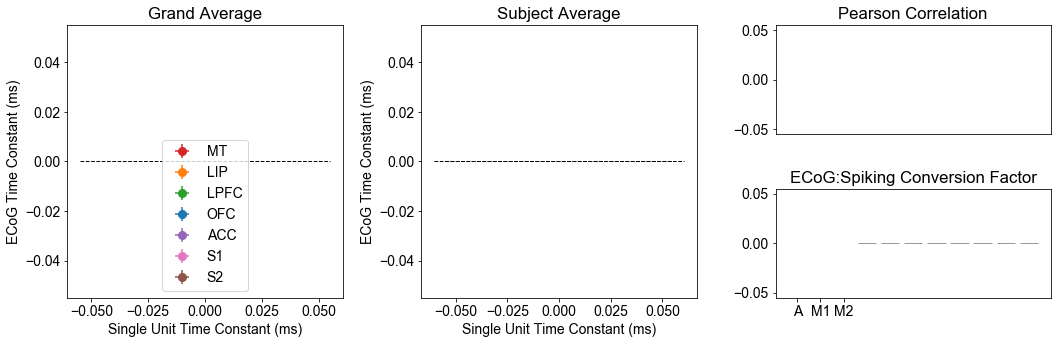

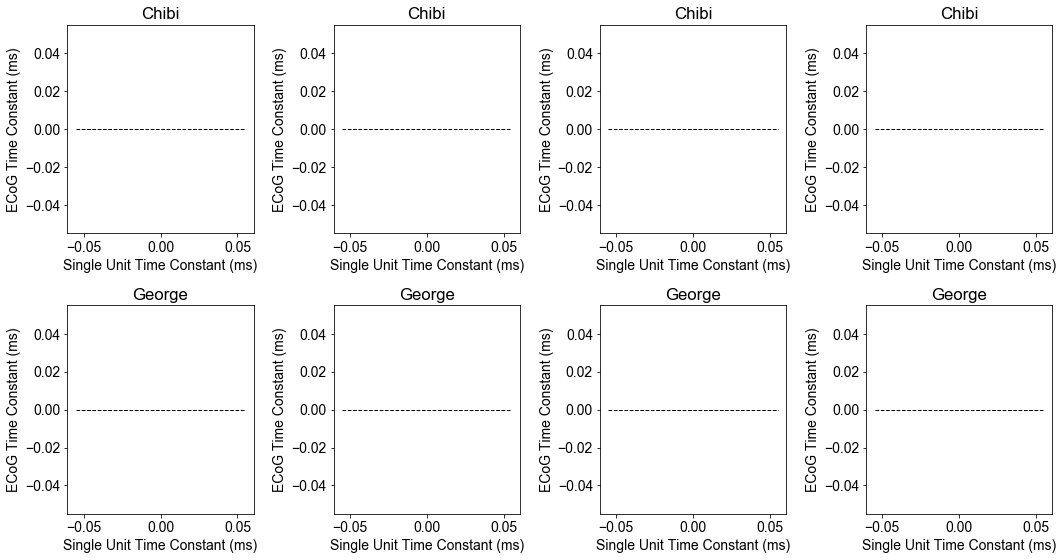

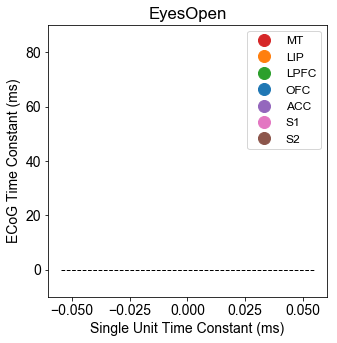

In [10]:
param_choice = [conds[0], 'psdmed', '1-70', 'knee', 'knee']
cell_ts_avg, ecog_ts_grandavg, per_subj, per_session = collect_results(param_choice, fooof_files, '')

plt.figure(figsize=(5,5))
plot_ts_correlations(ecog_ts_grandavg, cell_ts_avg, 'o')
plt.ylim([-10,90])
plt.legend(fontsize=12)
for ps in per_session:
    plot_ts_correlations(ps, cell_ts_avg, '.', ms=8, plot_cf=False, plot_regr=False, show_legend=False)

plt.title(param_choice[0])

-0.7699510596082635


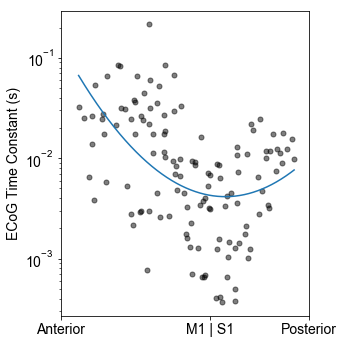

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


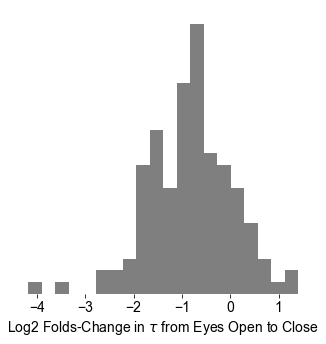

In [25]:
chibi_ctx_file = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/GridLocations/20110621KTMD_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_2Dimg/ChibiMap.mat'
ctx_mat = io.loadmat(chibi_ctx_file, squeeze_me=True)
# #plt.figure(figsize=(5,5))
# plt.scatter(ctx_mat['X'], -ctx_mat['Y'], s=40, c=np.log10(tau_from_knee(bg[:,1])))
# plt.box('off')

f_eo = 'psdmed_1-70_knee_5peaks_0_EyesOpen_Propofol_20120730PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz.json'
f_ec = 'psdmed_1-70_knee_5peaks_1_EyesClosed_Propofol_20120730PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz.json'

#f_eo = 'psdmed_1-70_knee_5peaks_0_EyesOpen_Propofol_20120802PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz.json'
#f_ec = 'psdmed_1-70_knee_5peaks_1_EyesClosed_Propofol_20120802PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz.json'

fg = FOOOFGroup()
fg.load(f_eo, fooof_path)
bg_eo = fg.get_all_data('background_params')
fg.load(f_ec, fooof_path)
bg_ec = fg.get_all_data('background_params')


W_quad = np.polyfit(ctx_mat['X'], np.log10(tau_from_knee(bg_eo[:,1])), 2)
x_fit = np.arange(ctx_mat['X'].min(), ctx_mat['X'].max(), 1)
fit_tau = np.matmul(W_quad, np.array([x_fit**2,x_fit,np.ones_like(x_fit)]))

plt.figure(figsize=(5,5))
plt.semilogy(ctx_mat['X'],tau_from_knee(bg_eo[:,1]), '.k', ms=10, alpha=0.5)
plt.plot(x_fit,10**(fit_tau), '-')


plt.xticks([0,600,1000],['Anterior','M1 | S1','Posterior'])
plt.ylabel('ECoG Time Constant (s)')
plt.tight_layout()

plt.figure(figsize=(5,5), tight_layout=True)
X = np.array([tau_from_knee(bg_eo[:,1]), tau_from_knee(bg_ec[:,1])])
print(np.nanmedian(np.log2(X[1,:]/X[0,:])))
plt.hist(np.log2(X[1,:]/X[0,:]), 20, color='k', alpha=0.5);
plt.yticks([])
#plt.xticks(range(-4,2),range(-8,4,2))
plt.xlabel(r'Log2 Folds-Change in $\tau$ from Eyes Open to Close')
plt.box('off')
#plt.semilogy(ctx_mat['X'],tau_from_knee(bg_eo[:,1]), '.k', ms=10, alpha=0.5)

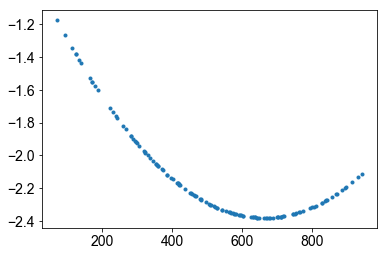

In [19]:
plt.plot(ctx_mat['X'],fit_tau, '.')

In [6]:
psds_regen = 10**np.array([fg.get_fooof(ind, regenerate=True).fooofed_spectrum_ for ind in range(len(fg))])
plt.figure(figsize=(4.5,4))
ax = plt.subplot()
plt.loglog(fg.freqs,psds_regen[6,:], 'k');
ax.axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([1,5,10,50], ['1','5','10','50'])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
#plt.box('off')

NameError: name 'fg' is not defined

In [46]:
# 10sec
fooof_path = '/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/'
fooof_files = sorted([ff for ff in os.listdir(fooof_path) if '.npz' in ff])
for p_c in conds[:2]:
    for p_p in mean_or_med:
        for p_bg in fixed_or_knee:
            if p_bg is 'fixed':
                for p_f in frange_params[2:]:
                    for p_ff in ['slope','offset', 'error']:
                        param_choice = [p_c, p_p, p_f, p_bg, p_ff]
                        print(param_choice)
                        output_name = 'timescale_results/10sec/'+'_'.join(param_choice)
                        collect_results(param_choice, fooof_files, output_name)
                        plt.close('all')
            else:
                for p_ff in fit_feats:
                    param_choice = [p_c, p_p, frange_params[3], p_bg, p_ff]
                    print(param_choice)
                    output_name = 'timescale_results/10sec/'+'_'.join(param_choice)
                    collect_results(param_choice, fooof_files, output_name)
                    plt.close('all')

['EyesOpen', 'psdmean', '30-70', 'fixed', 'slope']
Grand Average
Subject Average


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Per Session
['EyesOpen', 'psdmean', '30-70', 'fixed', 'offset']
Grand Average
Subject Average
Per Session
['EyesOpen', 'psdmean', '30-70', 'fixed', 'error']
Grand Average
Subject Average
Per Session
['EyesOpen', 'psdmean', '0-70', 'fixed', 'slope']
Grand Average
Subject Average
Per Session
['EyesOpen', 'psdmean', '0-70', 'fixed', 'offset']
Grand Average
Subject Average
Per Session
['EyesOpen', 'psdmean', '0-70', 'fixed', 'error']
Grand Average
Subject Average
Per Session
['EyesOpen', 'psdmean', '0-7', 'fixed', 'slope']
Grand Average
Subject Average
Per Session
['EyesOpen', 'psdmean', '0-7', 'fixed', 'offset']
Grand Average
Subject Average
Per Session
['EyesOpen', 'psdmean', '0-7', 'fixed', 'error']
Grand Average
Subject Average
Per Session
['EyesOpen', 'psdmean', '0-70', 'knee', 'knee']
Grand Average
Subject Average


/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in power
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice
/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Per Session
Regression did not converge.
['EyesOpen', 'psdmean', '0-70', 'knee', 'slope']
Grand Average
Subject Average
Per Session
['EyesOpen', 'psdmean', '0-70', 'knee', 'kneeslope']
Grand Average
Subject Average


/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in power


Per Session
Regression did not converge.
['EyesOpen', 'psdmean', '0-70', 'knee', 'offset']
Grand Average
Subject Average
Per Session
['EyesOpen', 'psdmean', '0-70', 'knee', 'error']
Grand Average
Subject Average
Per Session
['EyesOpen', 'psdmed', '30-70', 'fixed', 'slope']
Grand Average
Subject Average
Per Session
['EyesOpen', 'psdmed', '30-70', 'fixed', 'offset']
Grand Average
Subject Average
Per Session
['EyesOpen', 'psdmed', '30-70', 'fixed', 'error']
Grand Average
Subject Average
Per Session
['EyesOpen', 'psdmed', '0-70', 'fixed', 'slope']
Grand Average
Subject Average
Per Session
['EyesOpen', 'psdmed', '0-70', 'fixed', 'offset']
Grand Average
Subject Average
Per Session
['EyesOpen', 'psdmed', '0-70', 'fixed', 'error']
Grand Average
Subject Average
Per Session
['EyesOpen', 'psdmed', '0-7', 'fixed', 'slope']
Grand Average
Subject Average
Per Session
['EyesOpen', 'psdmed', '0-7', 'fixed', 'offset']
Grand Average
Subject Average
Per Session
['EyesOpen', 'psdmed', '0-7', 'fixed', 'erro

In [ ]:
fooof_path = '/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/'
fooof_files = sorted([ff for ff in os.listdir(fooof_path) if '.npz' in ff])

output_name = 'timescale_results/'+'_'.join(param_choice)
collect_results(param_choice, fooof_files, output_name)

# Macaque ECoG vs. Spiking Timescale
Single unit spiking timescale correlates with ECoG characteristic timescale across cortical areas. More generally, timescale increases moving from posterior to anterior regions of the brain, "up the cortical hierarchy".

However, there is a conversion factor of ~0.1 from ECoG to spiking, i.e. ECoG timescale is 1/10 of single unit spike timing timescale. Why is that?
1. timescale correlation is due to chance, or some other factor in the ECoG, e.g., dendritic/membrane integration constant
2. spiking is local output, whereas ECoG is (mostly) input, so the time constant measured in ECoG is spiking from the afferent region
3. single unit time constant is different from population time constant, which has been proposed as the benefit of asynchronous population spiking (faster reaction, e.g., van Vreeswijk, Destexhe)
4. local recurrent dendritic processes "filter" spiking, most likely in a low-pass fashion. Thus, whatever process with the highest time constant (lower frequency knee) will dominate in the retrieved timescale
5. they have nothing to do with each other and this is just random

**Should try gamma or broadband power autocorrelation over time to match with the spiking timescale.**

# Slope vs. Knee
Current points of investigation:
- Median fit knee is most consistent in correlating with timescale, and in general, produces more robust fits for the PSD (less nans, i.e., negative knees).

- When fit with knee, slope also (negative) correlates with single unit time constant. However, when just fit using a line in the full range, slope does NOT correlate with time constant. This is surprising, as I would have expected the knee-removed slope to be independent of the timescale, and the non-knee-removed slope fits are essentially corrupted by the knee. This indicates that the characteristic timescale (in exponential decay) is correlated with the power-law decay (???), suggesting multiple processes with multiple temporal time characteristics.

- For example, exponential decay constant (knee) may arise from synaptic time constant, while the power law relation may be from population spiking autocorrelation.

- need to check this with just linear range fits.

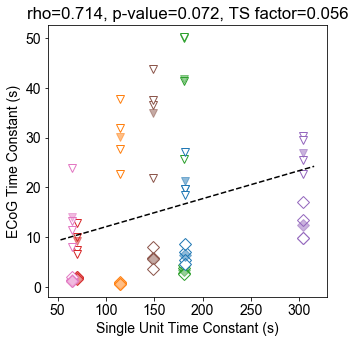

In [84]:
_, subj_ind = np.unique(subj, return_inverse=True) # get subject indices
CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers=['D','v']

#plotting
C_ord = [3,1,2,0,4,6,5]
plt.figure(figsize=(5,5))
for i,key in enumerate(cell_ts.keys()):
    curr_c=CKEYS[C_ord[i]]
    for s in np.unique(subj_ind):
        plt.plot(cell_ts_avg[key][0]*np.ones(sum(subj_ind==s)), ecog_ts_avg[key][subj_ind==s,0], markers[s], alpha=1, ms=8, mfc='w',color=curr_c)
        plt.plot(cell_ts_avg[key][0], ecog_ts_avg[key][subj_ind==s,0].mean(), markers[s], alpha=0.5, ms=8, color=curr_c)
#    plt.plot(cell_ts_avg[key][0], ecog_ts_avg[key][:,0].mean(), 'o', ms=12, label=key, color=curr_c)
#    plt.errorbar(cell_ts_avg[key][0], ecog_ts_avg[key][:,0].mean(),ecog_ts_avg[key][:,0].std(),cell_ts_avg[key][1], 'o', ms=12, label=key, color=curr_c)


plt.legend()
plt.xlabel('Single Unit Time Constant (s)')
plt.ylabel('ECoG Time Constant (s)')

# stats on grand average
ts_means = np.array([[cell_ts_avg[key][0], ecog_ts_avg[key][:,0].mean()] for key in cell_ts.keys()])
W = np.polyfit(ts_means[:,0],ts_means[:,1],1)
XL = np.array(plt.xlim())
plt.plot(XL, XL*W[0]+W[1], 'k--')
rho,pv = sp.stats.pearsonr(ts_means[:,0], ts_means[:,1])
plt.title('rho=%.3f, p-value=%.3f, TS factor=%0.3f'%(rho,pv,W[0]));